<a href="https://colab.research.google.com/github/thisisSHAX/ML_Ops_Project-/blob/main/Development/Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('https://drive.google.com/uc?export=download&id=16Pd-BdhzNMzPqPWD6XEu_XFZaGrSqFUz')
df.head()

,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who completed the test,Class/ASD Traits
0,1,0,0,0,0,0,0,1,1,0,1,28,3,f,middle eastern,yes,no,family member,No
1,2,1,1,0,0,0,1,1,0,0,0,36,4,m,White European,yes,no,family member,Yes
2,3,1,0,0,0,0,0,1,1,0,1,36,4,m,middle eastern,yes,no,family member,Yes
3,4,1,1,1,1,1,1,1,1,1,1,24,10,m,Hispanic,no,no,family member,Yes
4,5,1,1,0,1,1,1,1,1,1,1,20,9,f,White European,no,yes,family member,Yes


In [3]:
x_columns = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','Age_Mons','Sex','Ethnicity','Jaundice','Family_mem_with_ASD']
cat_features = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','Sex','Ethnicity','Jaundice','Family_mem_with_ASD']
num_features = list(set(x_columns) - set(cat_features))

In [4]:
encoded_df = pd.get_dummies(df[x_columns], columns=cat_features, drop_first = True)
encoded_df.sample(5)

,Age_Mons,A1_1,A2_1,A3_1,A4_1,A5_1,A6_1,A7_1,A8_1,A9_1,A10_1,Sex_m,Ethnicity_Latino,Ethnicity_Native Indian,Ethnicity_Others,Ethnicity_Pacifica,Ethnicity_White European,Ethnicity_asian,Ethnicity_black,Ethnicity_middle eastern,Ethnicity_mixed,Ethnicity_south asian,Jaundice_yes,Family_mem_with_ASD_yes
820,18,0,0,0,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1
62,36,1,1,0,0,1,1,1,1,1,1,1,0,0,0,0,1,0,0,0,0,0,1,0
82,36,1,1,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
835,31,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
676,32,1,1,0,1,0,1,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [5]:
x_features = list(encoded_df.columns)

In [6]:
X = encoded_df
Y = pd.get_dummies(df['Class/ASD Traits '], drop_first=True)
#Checking imbalance
Y.sum()/len(Y)

Yes    0.690702
dtype: float64

In [7]:
from sklearn.model_selection import train_test_split
# Splitting
train_X, test_X, train_Y, test_Y = train_test_split(df[x_columns], Y, test_size=0.2, random_state=1)
train_X, prod_X, train_Y, prod_Y = train_test_split(train_X, train_Y, test_size=0.25, random_state=2) # 0.25 x 0.8 = 0.2

# Splitting after One - Hot Encoding
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train, X_prod, Y_train, Y_prod = train_test_split(X_train, Y_train, test_size=0.25, random_state=2) # 0.25 x 0.8 = 0.2

## Modelling

In [8]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 33.3 MB/s 
     |████████████████████████████████| 180 kB 55.3 MB/s 
     |████████████████████████████████| 97 kB 7.6 MB/s 
     |████████████████████████████████| 140 kB 60.0 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=c2a7534a13776fca50fa8a50fec266705adbc57af759584b343cc8c9e9dbf585
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=ad6125833f3d4b3ce43363e4fea7f8f803815c4da523046bd3e91ff16a0f826f
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [9]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [18]:
import os

In [19]:
os.environ["WANDB_API_KEY"] = "26ff855733a63e9d999357d3e3bd1eb135cff5a5"

In [21]:
def run_model_experiment(model,
                         x_train,
                         y_train,
                         x_test,
                         y_test,
                         name,
                         config = None,
                         tags = None):
  
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  y_probas = model.predict_proba(x_test)
  features = x_train.columns

  wandb.init(project='AutismScreening', config=config, tags = tags)
  wandb.run.name = name

  acc = metrics.accuracy_score(y_test, model.predict(x_test))
  prec = metrics.precision_score(y_test, model.predict(x_test))
  rec = metrics.recall_score(y_test, model.predict(x_test))
  f1 = metrics.f1_score(y_test, model.predict(x_test))
  
  #rmse = np.sqrt(mean_squared_error(y_test, model.predict(x_test)))
  #r2 = model.score(x_test, y_test)

  wandb.log( {"Accuracy" : acc, 
              "Precision": prec,
              "Recall": rec,
              "F1 score" : f1} )
  
  wandb.sklearn.plot_classifier(model, x_train, x_test, y_train, y_test, 
                                y_pred, y_probas, features, model_name=name)
 
  #wandb.sklearn.plot_regressor(model, 
  #                             x_train, 
  #                             x_test, 
  #                             y_train, 
  #                             y_test,  
  #                             model_name=name)
  
  wandb.Artifact(name, 
                 type = 'model',
                 description = config)

  wandb.save()
  wandb.finish()

  return model

### Logistic Regression

In [12]:
#wandb.init(project="ML_Ops_Project", entity="thisisshax")

In [13]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(max_iter= 10000)

# fit the model with data
logreg.fit(X_train,Y_train)

#
Y_pred=logreg.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0.5, 257.44, 'Predicted label')

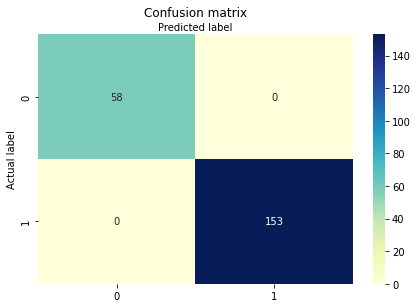

In [14]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred)

# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [15]:
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
print("Precision:",metrics.precision_score(Y_test, Y_pred))
print("Recall:",metrics.recall_score(Y_test, Y_pred))
print("f1 score:",metrics.f1_score(Y_test, Y_pred))
print("Specificity", cnf_matrix.ravel()[0]/(cnf_matrix.ravel()[0]+cnf_matrix.ravel()[1]))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
f1 score: 1.0
Specificity 1.0


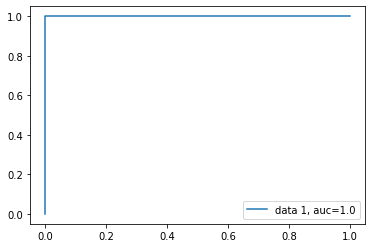

In [16]:
Y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  Y_pred_proba)
auc = metrics.roc_auc_score(Y_test, Y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [22]:
lr_model = run_model_experiment(logreg,
                                   X_train,
                                   Y_train,
                                   X_test,
                                   Y_test,
                                   name = 'LogisticRegressionModel',
                                   tags = ['LogisticRegression'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
wandb: Currently logged in as: thisisshax (use `wandb login --relogin` to force relogin)


wandb: 
wandb: Plotting LogisticRegressionModel.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
wandb: Logged feature importances.
wandb: Logged confusion matrix.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
wandb: Logged summary metrics.
wandb: Logged class proportions.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples

Accuracy,▁
F1 score,▁
Precision,▁
Recall,▁
Accuracy,1.0
F1 score,1.0
Precision,1.0
Recall,1.0


### KNN

In [23]:
#Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=10)

#Train the model using the training sets
knn.fit(X_train, Y_train)

#Predict the response for production dataset
Y_pred = knn.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Text(0.5, 257.44, 'Predicted label')

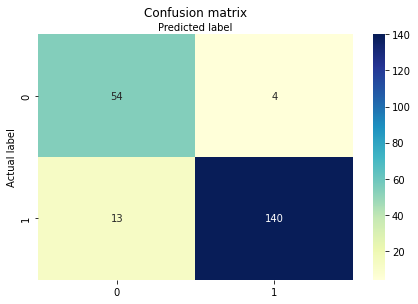

In [24]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred)
cnf_matrix

# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [25]:
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
print("Precision:",metrics.precision_score(Y_test, Y_pred))
print("Recall:",metrics.recall_score(Y_test, Y_pred))
print("f1 score:",metrics.f1_score(Y_test, Y_pred))
print("Specificity", cnf_matrix.ravel()[0]/(cnf_matrix.ravel()[0]+cnf_matrix.ravel()[1]))

Accuracy: 0.919431279620853
Precision: 0.9722222222222222
Recall: 0.9150326797385621
f1 score: 0.9427609427609427
Specificity 0.9310344827586207


In [26]:
knn_model = run_model_experiment(knn,
                                   X_train,
                                   Y_train,
                                   X_test,
                                   Y_test,
                                   name = 'KNNModel',
                                   tags = ['KNN'])

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


wandb: 
wandb: Plotting KNNModel.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
wandb: WARNING could not find any of attributes feature_importances_, feature_log_prob_, coef_ on classifier. Cannot plot feature importances.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
wandb: Logged summary metrics.
wandb: Logged class proportions.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validatio

Accuracy,▁
F1 score,▁
Precision,▁
Recall,▁
Accuracy,0.91943
F1 score,0.94276
Precision,0.97222
Recall,0.91503


### Decision Tree

In [27]:
from sklearn.tree import DecisionTreeClassifier
#Create Decision Tree
dt = DecisionTreeClassifier()

#Train the model using the training sets
dt.fit(X_train, Y_train)

#Predict the response for production dataset
Y_pred = dt.predict(X_test)

Text(0.5, 257.44, 'Predicted label')

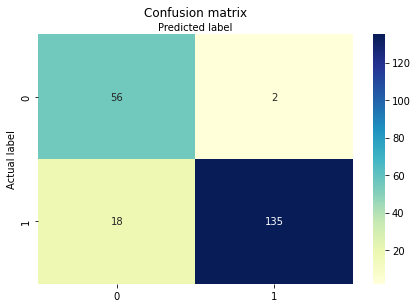

In [28]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred)
cnf_matrix

# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [29]:
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
print("Precision:",metrics.precision_score(Y_test, Y_pred))
print("Recall:",metrics.recall_score(Y_test, Y_pred))
print("f1 score:",metrics.f1_score(Y_test, Y_pred))
print("Specificity", cnf_matrix.ravel()[0]/(cnf_matrix.ravel()[0]+cnf_matrix.ravel()[1]))

Accuracy: 0.9052132701421801
Precision: 0.9854014598540146
Recall: 0.8823529411764706
f1 score: 0.9310344827586207
Specificity 0.9655172413793104


In [30]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

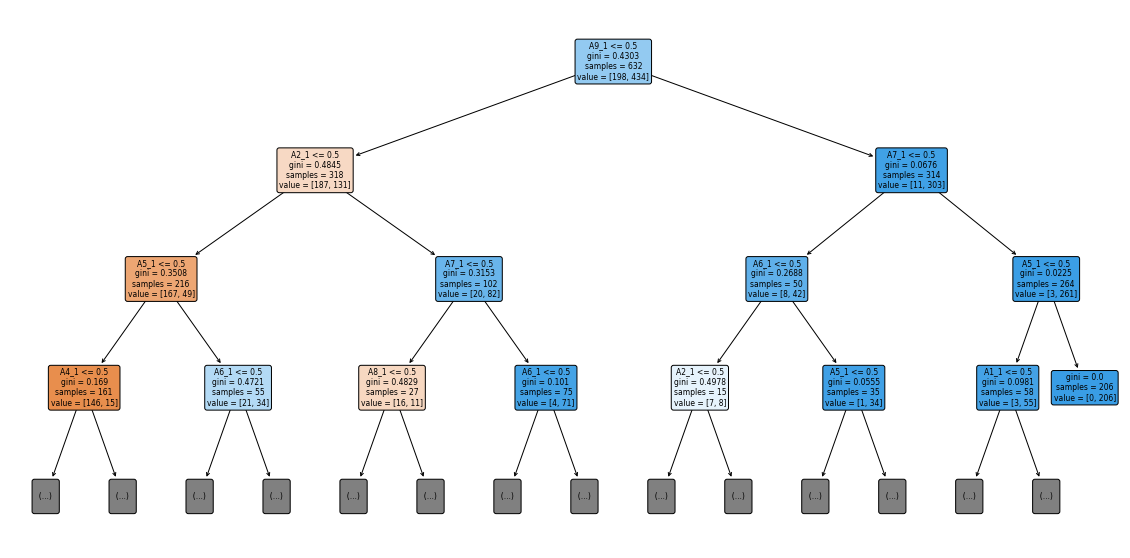

In [31]:
from sklearn.tree import plot_tree
dec_tree = plot_tree(decision_tree=dt, feature_names = X.columns, filled = True , max_depth = 3, precision = 4, rounded = True)

In [32]:
dt_model = run_model_experiment(dt,
                                   X_train,
                                   Y_train,
                                   X_test,
                                   Y_test,
                                   name = 'DecisionTree',
                                   tags = ['DecisionTree'])

wandb: 
wandb: Plotting DecisionTree.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
wandb: Logged feature importances.
wandb: Logged confusion matrix.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
wandb: Logged summary metrics.
wandb: Logged class proportions.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sample

Accuracy,▁
F1 score,▁
Precision,▁
Recall,▁
Accuracy,0.891
F1 score,0.91986
Precision,0.98507
Recall,0.86275


In [36]:
api = wandb.Api()

all_runs = api.runs("thisisshax/AutismScreening", order="+summary_metrics.Accuracy")

for run in all_runs:
  print(f"Model Name: {run.name} and Accuracy {run.summary.get('Accuracy')}")
  print(run.config)

Model Name: DecisionTree and Accuracy 0.8909952606635071
{}
Model Name: KNNModel and Accuracy 0.919431279620853
{}
Model Name: LogisticRegressionModel and Accuracy 1
{}


### Pipeline

In [37]:
!pip install --upgrade category_encoders

     |████████████████████████████████| 82 kB 395 kB/s 


In [38]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

In [39]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer1 = OneHotEncoder(drop='first', sparse=False)
categorical_transformer2 = TargetEncoder()

In [40]:
preprocessor1 = ColumnTransformer(transformers=[('num', numeric_transformer, num_features),('cat', categorical_transformer1, cat_features)])
preprocessor2 = ColumnTransformer(transformers=[('num', numeric_transformer, num_features),('cat', categorical_transformer2, cat_features)])

In [41]:
train_X, test_X, train_Y, test_Y = train_test_split(df[x_columns], Y, test_size=0.2, random_state=1)

train_X, prod_X, train_Y, prod_Y = train_test_split(train_X, train_Y, test_size=0.25, random_state=2) # 0.25 x 0.8 = 0.2

In [42]:
clf1 = Pipeline(steps=[("preprocessor", preprocessor1),("classifier", LogisticRegression(random_state=100))])
clf1.fit(train_X, train_Y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age_Mons']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['A1', 'A2', 'A3', 'A4', 'A5',
                                                   'A6', 'A7', 'A8', 'A9',
                                                   'A10', 'Sex', 'Ethnicity',
                                                   'Jaundice',
                                                   'Family_mem_with_ASD'])])),
                ('classifier', LogisticRegression(random_state=100))])

In [43]:
clf2 = Pipeline(steps=[("preprocessor", preprocessor2),("classifier", LogisticRegression(random_state=100))])
clf2.fit(train_X, train_Y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age_Mons']),
                                                 ('cat', TargetEncoder(),
                                                  ['A1', 'A2', 'A3', 'A4', 'A5',
                                                   'A6', 'A7', 'A8', 'A9',
                                                   'A10', 'Sex', 'Ethnicity',
                                                   'Jaundice',
                                                   'Family_mem_with_ASD'])])),
                ('classifier', LogisticRegression(random_state=100))])

In [44]:
pred1_Y = clf1.predict(test_X)

Text(0.5, 637.6, 'Predicted label')

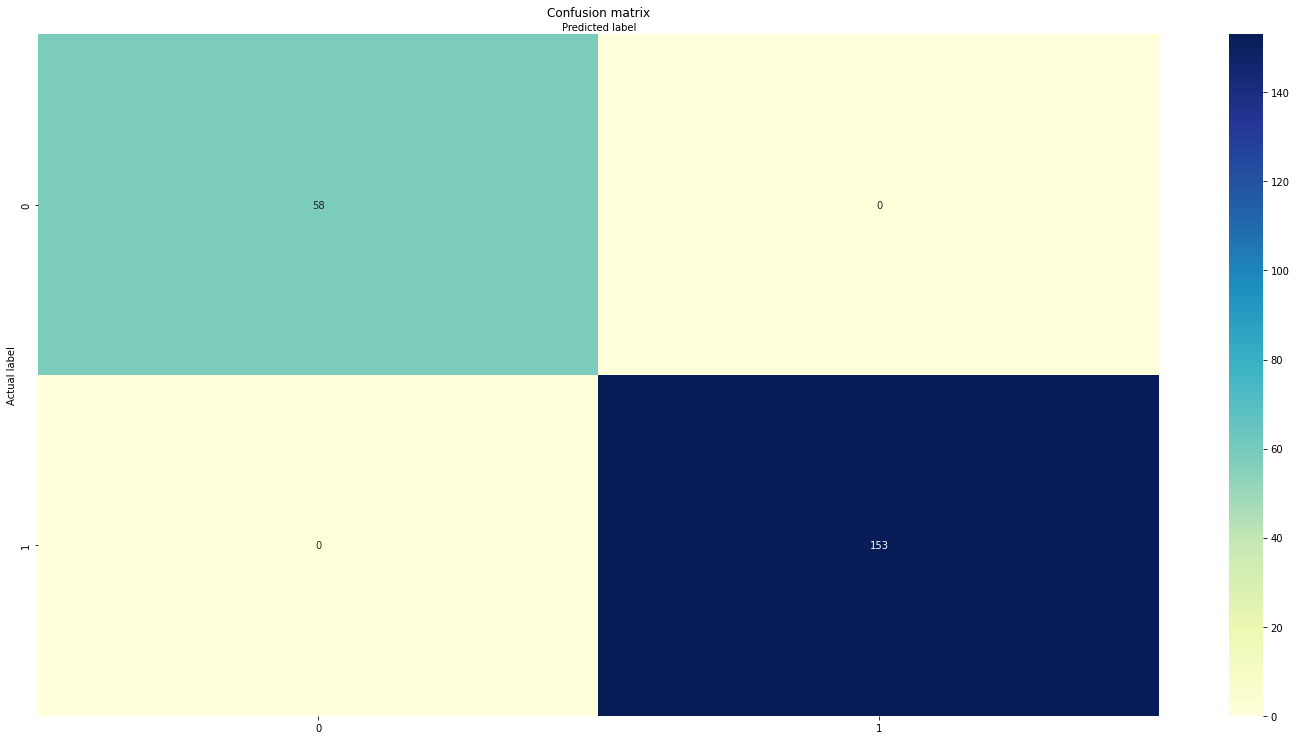

In [45]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(test_Y, pred1_Y)
cnf_matrix

# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [46]:
print("Accuracy:",metrics.accuracy_score(test_Y, pred1_Y))
print("Precision:",metrics.precision_score(test_Y, pred1_Y))
print("Recall:",metrics.recall_score(test_Y, pred1_Y))
print("f1 score:",metrics.f1_score(test_Y, pred1_Y))
print("Specificity", cnf_matrix.ravel()[0]/(cnf_matrix.ravel()[0]+cnf_matrix.ravel()[1]))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
f1 score: 1.0
Specificity 1.0


In [47]:
pred2_Y = clf2.predict(test_X)

Text(0.5, 637.6, 'Predicted label')

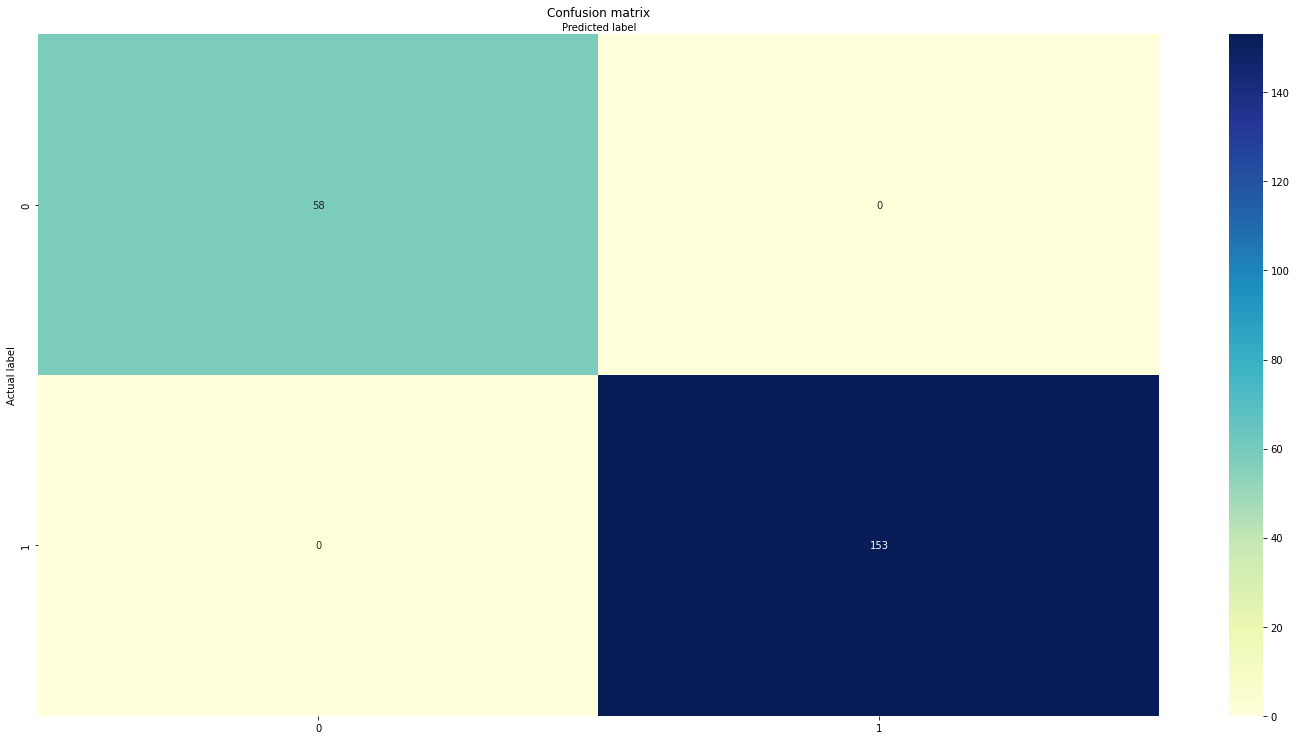

In [48]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(test_Y, pred2_Y)
cnf_matrix

# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [49]:
print("Accuracy:",metrics.accuracy_score(test_Y, pred2_Y))
print("Precision:",metrics.precision_score(test_Y, pred2_Y))
print("Recall:",metrics.recall_score(test_Y, pred2_Y))
print("f1 score:",metrics.f1_score(test_Y, pred2_Y))
print("Specificity", cnf_matrix.ravel()[0]/(cnf_matrix.ravel()[0]+cnf_matrix.ravel()[1]))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
f1 score: 1.0
Specificity 1.0
